# Analysis of DEA results - efficiency, slacks, peer relations

***
## Imports and data

In [440]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import statsmodels.api as sm
import scipy.stats
from fill_and_map import map_inds_sdg, fill_econ, map_econ_sdg, fill_inds_trans
fpath = Path('data_raw/SDG-DEA_indicators_V5_20200708.xlsx')

In [2]:
# read income and efficiency data
ic_in = pd.read_csv(Path('analysis_data/income_cats.csv'), index_col=0, header=None)
ef_in_io = pd.read_csv(Path('analysis_data/eff_io.csv'), index_col=0)
ef_in_oo = pd.read_csv(Path('analysis_data/eff_oo.csv'), index_col=0)

# concat into one dataframe
effio = pd.concat((ic_in, ef_in_io), axis=1)
effoo = pd.concat((ic_in, ef_in_oo), axis=1)
effio.columns = ['income',*effio.columns[1:]]
effoo.columns = ['income',*effoo.columns[1:]]
inc = effio['income'].unique()

In [23]:
# general plot data
cmap = np.divide([[140,107,177],
                 [199,233,180],
                 [158,188,218],
                 [65,182,196]],255)       
nbins = 12


***
## Improvement targets/slacks

In [14]:
# read slacks
orient='io'
spath = Path('analysis_data/slacks_{0}.xlsx'.format(orient))
writer = pd.ExcelWriter(spath, engine='xlsxwriter')
slacks = pd.DataFrame(columns=range(1,18), index=effio.index.rename(None))
for s in range(1,18):
    slacks[s] = pd.read_excel(writer, sheet_name = 'sdg{0}'.format(s), index_col=0, usecols=[0,1])


In [146]:
sl3 = pd.read_excel(spath, sheet_name='sdg3', index_col=0)

In [148]:
slacks[3]

AFG     15.692448
AGO     42.737592
ALB      0.000000
AND      0.000000
ARE      0.000000
          ...    
WSM      0.000000
YEM      0.000000
ZAF    476.051210
ZMB      0.000000
ZWE     92.984772
Name: 3, Length: 193, dtype: float64

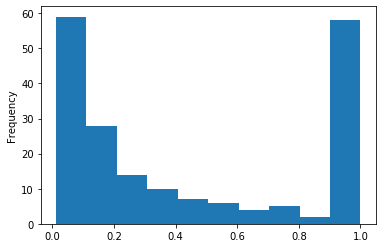

In [24]:
effio['sdg1'].plot.hist()

***
## Analysis of economic data
Things to add:
- income categories (categorical) vs. spend for each economic input
- same thing, but spend as percentage of GDP

In [17]:
econ = fill_econ(fpath)
map_econ = map_econ_sdg(fpath)
inds = fill_inds_trans(fpath)

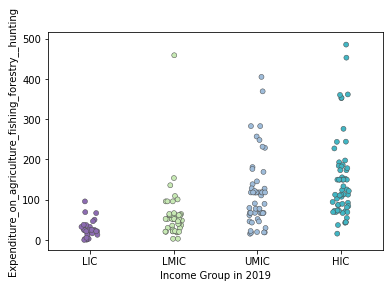

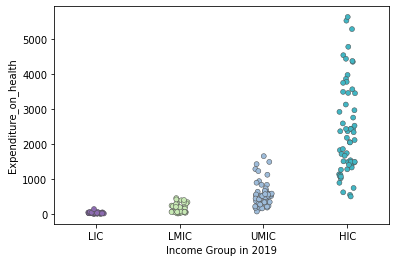

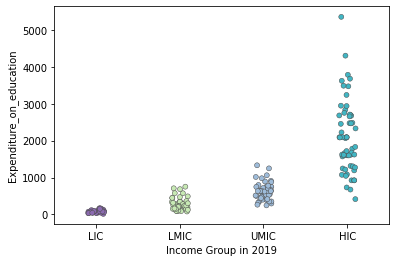

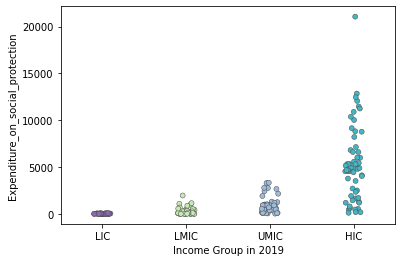

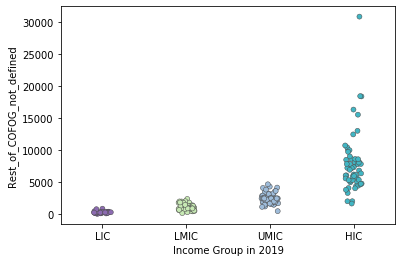

In [36]:
import seaborn as sns
for ii in range(1,6):
    fig, ax = plt.subplots(1, 1)
    ax = sns.stripplot(x=econ.columns[0], y=econ.columns[ii], data=econ, palette=cmap, linewidth=.5)

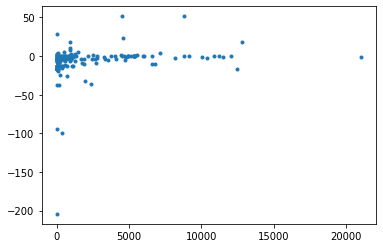

In [257]:
plt.scatter(econ['Expenditure_on_social_protection'],inds['sdg10_fsi7'], marker='.', mark)

In [66]:
for ii in econ.columns[1:]:
    print(ii, econ.loc[:,ii].sort_values()[:10])

Expenditure_on_agriculture_fishing_forestry__hunting MWI    0.376766
COD    1.021209
MDG    1.919638
GNB    2.452220
LBR    3.143710
BDI    3.148916
NGA    3.159543
SDN    3.322496
CAF    4.024145
SLE    5.833959
Name: Expenditure_on_agriculture_fishing_forestry__hunting, dtype: float64
Expenditure_on_health COD     5.426226
CAF     5.598660
NER    13.014719
BDI    13.707434
HTI    14.137400
TCD    14.223931
GMB    17.153876
GIN    17.465929
BGD    17.763416
UGA    17.932908
Name: Expenditure_on_health, dtype: float64
Expenditure_on_education COD    15.789776
TCD    35.431022
BDI    38.158755
LBR    38.684400
NER    42.686542
UGA    45.204557
HTI    49.135771
MWI    49.310943
GMB    52.163864
MDG    52.180982
Name: Expenditure_on_education, dtype: float64
Expenditure_on_social_protection BDI    1.523048
TCD    1.580437
BFA    1.859648
CAF    2.799330
STP    3.944693
PNG    4.233124
TZA    5.028488
HTI    5.301525
UGA    5.379872
LBR    5.988019
Name: Expenditure_on_social_protection, d

***
## Analysis of peer relationships

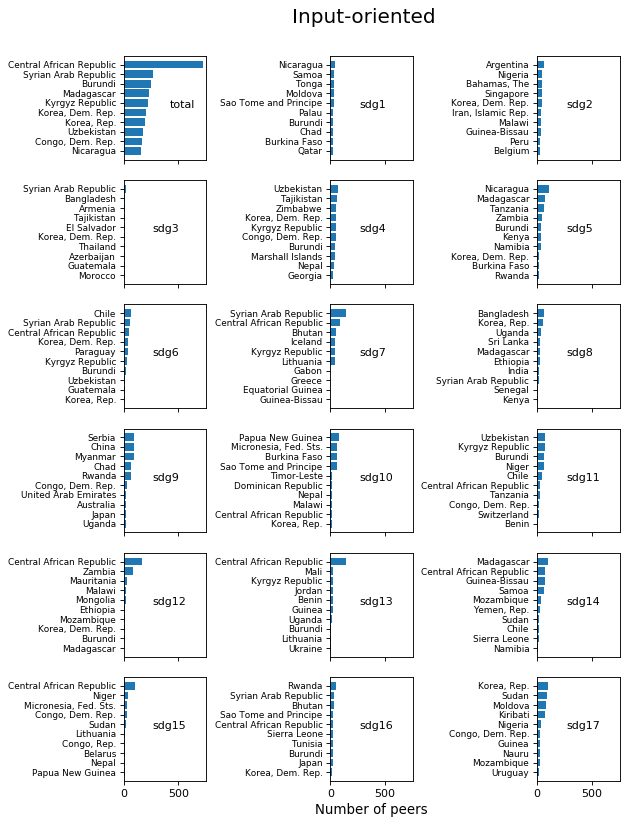

In [159]:
# # Peer analysis

# read peer excel file
orient = 'io'
cid = pd.read_csv('analysis_data/country_id.csv', index_col=[1]) # country id to transform from three-letter iso code to name
xls = pd.ExcelFile(Path('analysis_data/lambdas_{0}.xlsx'.format(orient))) # so we don't have to reload the file for each sheet
peer_data = {}
sdg_strings = ['sdg{0}'.format(ii) for ii in range(1,18)]
for s in sdg_strings:
    peer_data[s] = pd.read_excel(xls, s, index_col=[0])
    peer_data[s].columns = cid['c']
    peer_data[s].index = cid['c']

cutoff = 0.001 # so we don't consider very weak peer relationships
peer_counts = {}

# count number of times a country has acted as peer, minus "self-peering"
for s in sdg_strings:
    peer_counts[s] = peer_data[s][peer_data[s] > cutoff].count() - np.diag(peer_data[s])

# plot peer counts
nc = 10 # number of countries to display

y_pos = np.arange(nc)
fig, ax = plt.subplots(6, 3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(wspace=1.5)
ax = ax.ravel()

for jj, ax0 in enumerate(ax):
    sdg_n = sdg_strings[jj-1]
    if jj==0:
        plot_counts = sum(peer_counts.values()).sort_values()[-nc:]
        ax0.barh(y_pos, plot_counts)
        ax0.text(.55,.5,'total',transform=ax0.transAxes)
    else:
        plot_counts = peer_counts[sdg_n].sort_values()[-nc:]
        ax0.barh(y_pos, plot_counts)
        ax0.text(.35,.5,sdg_n,transform=ax0.transAxes)

    ax0.set_yticks(y_pos)
    ax0.set_yticklabels(plot_counts.index, fontsize=8)

# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel("Number of peers", fontsize=12)
# ax3.set_ylabel("Counts", fontsize=12)

if orient=='oo':
    fig.suptitle('Output-oriented', y=0.93, fontsize=18)
    plt.savefig('figures/peercount_all_oo.png', bbox_inches='tight', dpi=600)
elif orient=='io':
    fig.suptitle('Input-oriented', y=0.93, fontsize=18)
    plt.savefig('figures/peercount_all_io.png', bbox_inches='tight', dpi=600)



***
## Miscellaneous 
### Desired/undesired outputs

In [40]:
# number of desired/undesired outputs for each SDG
map_inds = map_inds_sdg(fpath)
use_inds_path = Path('data_raw/use_inds.xlsx')
use_inds = pd.read_excel(use_inds_path, usecols='A:D')
skip_inds = use_inds['ind_name'][use_inds['use']=='no']
undes_inds = use_inds['ind_name'][use_inds['issue']=='undesired']


for ii in map_inds:
    n_ind = len(set(map_inds[ii]) - set(skip_inds))
    n_undes = len(set(map_inds[ii]) & set(undes_inds) - set(skip_inds))
    n_des = n_ind - n_undes
    print('SDG {0}:'.format(ii),'{0} ({1}/{2})'.format(n_ind, n_des, n_undes))


SDG 1: 4 (4/0)
SDG 2: 8 (6/2)
SDG 3: 17 (15/2)
SDG 4: 3 (3/0)
SDG 5: 4 (4/0)
SDG 6: 5 (3/2)
SDG 7: 3 (3/0)
SDG 8: 6 (5/1)
SDG 9: 5 (5/0)
SDG 10: 8 (5/3)
SDG 11: 3 (3/0)
SDG 12: 6 (0/6)
SDG 13: 4 (2/2)
SDG 14: 4 (2/2)
SDG 15: 6 (4/2)
SDG 16: 8 (6/2)
SDG 17: 4 (3/1)


In [263]:
pi = Path('analysis_data/updated_sdg10/sdg10_eff_res_io.csv')
po = Path('analysis_data/updated_sdg10/sdg10_eff_res_oo.csv')
s10io = pd.read_csv(pi, sep='\t', index_col=[0])
s10oo = pd.read_csv(po, sep='\t', index_col=[0])

***
## Efficiency analysis

In [242]:
# read income and efficiency data
orient = 'io'
ic_in = pd.read_csv(Path('analysis_data/income_cats.csv'), index_col=0, header=None)
ef_in = pd.read_csv(Path('analysis_data/eff_{0}.csv'.format(orient)), index_col=0)

# concat into one dataframe
eff = pd.concat((ic_in, ef_in), axis=1)
eff.columns = ['income',*eff.columns[1:]]
inc = eff['income'].unique()

# effio = eff.copy()
# effoo = eff

### Single SDG

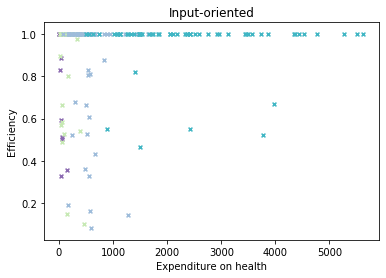

In [161]:
fig, ax = plt.subplots(1,1)
for ii,inc in enumerate(eff['income'].unique()):
    csel = effio.index[eff['income']==inc]
    ax.scatter(econ.loc[csel]['Expenditure_on_health'], effio.loc[csel]['sdg3'], s=15, c=cmap[ii,:].reshape(1,-1), marker='x')

ax.set_title('Input-oriented');
ax.set_xlabel('Expenditure on health');
ax.set_ylabel('Efficiency');

In [362]:
print('Proportion of countries with efficient health spending')
for ii in ['LIC','LMIC','UMIC','HIC']:
    ninc = effio['sdg3'][effio['income']==ii].shape[0]
    neff = sum(effio['sdg3'][effio['income']==ii]==1)
    print(ii, '\t', str(neff),'/',str(ninc), '\t', str(int(100*round(neff/ninc,2))), '%')

Proportion of countries with efficient health spending
LIC 	 27 / 34 	 79 %
LMIC 	 34 / 45 	 76 %
UMIC 	 39 / 55 	 71 %
HIC 	 53 / 59 	 90 %


In [355]:
ninc

59

In [235]:
# load peer data
peer_data = pd.read_excel(Path('analysis_data/lambdas_{0}.xlsx'.format(orient)), 'sdg3', index_col=[0])
for cc in peer_data.columns: # remove "self-peering" of efficient countries
    peer_data.loc[cc,cc] = 0

['total', 'LIC', 'LMIC', 'UMIC', 'HIC']

In [535]:
cutoff = 0.01
nc = 14 # number of countries to display

# count number of times a country has acted as peer to countries within each income category
peer_counts = pd.DataFrame(columns=effio['income'].unique(), index=effio.index.rename(None))
for ii in peer_counts.columns:
    cinc = effio.index[eff_io['income']==ii]
    peer_counts[ii] = peer_data.loc[cinc,:][peer_data.loc[cinc,:] > cutoff].count()
peer_counts['total'] = peer_counts.sum(axis=1)
peer_counts['income'] = effio['income']
# plot_counts = peer_counts.sort_values(by=['total'], ascending=False)[:14]

LIC  LMIC  UMIC  HIC
SYR    5     7     5    1
BGD    4     8     2    0
ARM    0     2     9    1
TJK    1     6     3    0
SLV    0     1     8    0
AZE    0     2     6    0
PRK    1     5     2    0
THA    0     1     6    1
MAR    0     0     6    1
GTM    0     1     5    1
UZB    0     1     6    0
JAM    0     0     6    0
PAK    1     4     1    0
COD    3     2     1    0

In [307]:
ii = 1


SYR    5
BGD    4
ARM    0
TJK    1
SLV    0
AZE    0
PRK    1
THA    0
MAR    0
GTM    0
UZB    0
JAM    0
PAK    1
COD    3
dtype: int64

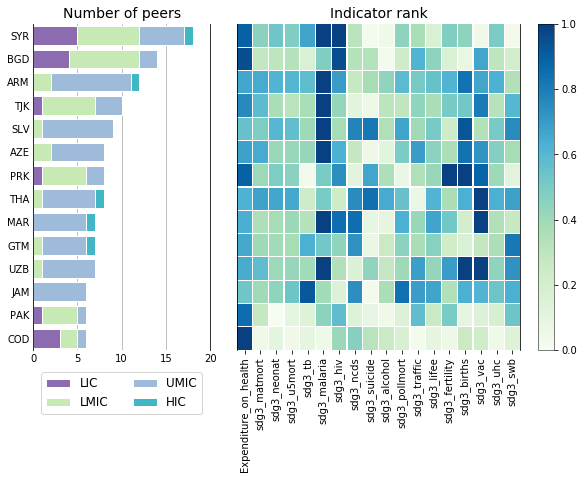

In [590]:
# Number of peers as horizontal bar chart, stacked by income category

import matplotlib.patheffects as path_effects
plotdata = peer_counts.sort_values(by=['total'], ascending=False)[:nc].iloc[:,:4].copy() # nc countries acting as peers most often
inc_col = {inc:cmap[ii,:] for ii,inc in enumerate(plotdata.columns)} # colours for each income category

fig, (ax,ax2) = plt.subplots(1, 2, figsize=(10,6), gridspec_kw={'width_ratios': [1, 2], 'wspace':0.1})
ax.invert_yaxis()
for ii, inc in enumerate(plotdata.columns):
    width = plotdata[inc]
    labels = plotdata.index
    starts = plotdata.iloc[:,:ii].sum(axis=1)
    ax.barh(labels, width, left=starts, color=cmap[ii,:], edgecolor='w', linewidth=1, zorder=2, label=inc)
ax.set_xlim(xmin=0, xmax=20)
ax.grid(axis='x', zorder=0)
ax.legend(ncol=int(len(plotdata.columns)/2), bbox_to_anchor=(0.5, -.05),loc='upper center', fontsize='large');
ax.set_yticks(np.arange(nc))
ax.set_ylim(ax.get_ylim()[0]+.5, ax.get_ylim()[1]-.5)
ax.tick_params(axis='both', which='both',length=0)
ax.set_title('Number of peers', fontsize='14')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# indicator ranks/percentiles

cols3 = [ii for ii in inds.columns if ii.startswith('sdg3')]
heat_inds = inds[cols3].rank(pct=True, method='max', axis=0).loc[plotdata.index,:]
heat_econ = econ[['Expenditure_on_health']].rank(pct=True, method='max', axis=0, ascending=False).loc[plotdata.index,:]
heatdata = pd.concat([heat_econ, heat_inds], axis=1)

sns.heatmap(heatdata, cmap='GnBu', linewidths=.1, ax=ax2, cbar_kws={})

# fix cutoff bug for first and last row
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(True)
# ax2.spines['top'].set_visible(True)
# ax2.spines['bottom'].set_visible(True)

ax2.set_title('Indicator rank', fontsize='14');
ax2.tick_params(left=False, labelleft=False) 

cbar = ax2.collections[0].colorbar
cbar.set_ticks(np.linspace(heatdata.min().min(),1,6))
cbar.set_ticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
cbar.outline.set_edgecolor('k')
cbar.outline.set_linewidth(.5)

# plt.savefig('figures/peers_ind_rank.png', bbox_inches='tight', dpi=300)

# # change colour of country names
# for ytick in ax.get_yticklabels():
#     print(ytick, ' ', ytick.get_text(), ' ', peer_counts.loc[ytick.get_text(),'income'], ' ', inc_col[peer_counts.loc[ytick.get_text(),'income']])
#     ytick.set_color(inc_col[peer_counts.loc[ytick.get_text(),'income']])
#     ytick.set_path_effects([path_effects.Stroke(linewidth=.3, foreground='dimgrey'),path_effects.Normal()])

In [494]:
cols3 = [ii for ii in inds.columns if ii.startswith('sdg3')]
heat_inds = inds[cols3].rank(pct=True, method='max', axis=0).loc[plotdata.index,:]
heat_econ = econ[['Expenditure_on_health']].rank(pct=True, method='max', axis=0, ascending=False).loc[plotdata.index,:]
heatdata = pd.concat([heat_econ, heat_inds], axis=1)

sns.set_palette('green')
sns.heatmap(heatdata, linewidths=.1)

# fix cutoff bug for first and last row
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

Text(0, 0.2, '0.2')

Expenditure_on_health  sdg3_matmort  sdg3_neonat  sdg3_u5mort   sdg3_tb  \
SYR               0.896373      0.461140     0.533679     0.492228  0.673575   
BGD               0.958549      0.284974     0.305699     0.331606  0.176166   
ARM               0.663212      0.652850     0.621762     0.611399  0.580311   
TJK               0.761658      0.585492     0.373057     0.316062  0.373057   
SLV               0.554404      0.497409     0.606218     0.569948  0.404145   
AZE               0.683938      0.652850     0.414508     0.419689  0.424870   
PRK               0.896373      0.409326     0.497409     0.461140  0.031088   
THA               0.626943      0.678756     0.663212     0.658031  0.243523   
MAR               0.642487      0.357513     0.383420     0.414508  0.331606   
GTM               0.658031      0.404145     0.393782     0.378238  0.637306   
UZB               0.647668      0.575130     0.409326     0.424870  0.393782   
JAM               0.533679      0.398964     0.445596     0.538860  0.922280   
PAK               0.860104      0.279793     0.005181     0.103627  0.150259   
COD               1.000000      0.051813     0.108808     0.046632  0.103627   
ATG               0.419689      0.761658     0.751295     0.751295  0.984456   
CHE               0.238342      0.948187     0.818653     0.860104  0.844560   
CYP               0.341969      0.896373     0.948187     0.963731  0.891192   
KEN               0.751295      0.098446     0.243523     0.248705  0.113990   

     sdg3_malaria  sdg3_hiv  sdg3_ncds  sdg3_suicide  sdg3_alcohol  \
SYR      1.000000  0.994819   0.316062      0.025907      0.051813   
BGD      0.487047  0.958549   0.336788      0.336788      0.025907   
ARM      1.000000  0.699482   0.274611      0.378238      0.440415   
TJK      1.000000  0.430052   0.124352      0.056995      0.310881   
SLV      1.000000  0.383420   0.777202      0.818653      0.352332   
AZE      1.000000  0.632124   0.279793      0.062176      0.124352   
PRK      0.507772  0.740933   0.113990      0.668394      0.357513   
THA      0.507772  0.243523   0.751295      0.844560      0.652850   
MAR      1.000000  0.854922   0.854922      0.093264      0.098446   
GTM      0.523316  0.445596   0.730570      0.067358      0.259067   
UZB      1.000000  0.347150   0.160622      0.440415      0.279793   
JAM      0.393782  0.155440   0.740933      0.031088      0.367876   
PAK      0.455959  0.575130   0.150259      0.093264      0.051813   
COD      0.051813  0.414508   0.471503      0.321244      0.264249   
ATG      0.689119  0.590674   0.259067      0.005181      0.554404   
CHE      1.000000  0.647668   0.989637      0.911917      0.901554   
CYP      0.689119  0.699482   0.891192      0.295337      0.854922   
KEN      0.165803  0.098446   0.818653      0.119171      0.316062   

     sdg3_pollmort  sdg3_traffic  sdg3_lifee  sdg3_fertility  sdg3_births  \
SYR       0.450777      0.373057    0.176166        0.487047     0.450777   
BGD       0.238342      0.621762    0.450777        0.176166     0.088083   
ARM       0.590674      0.512953    0.559585        0.621762     0.834197   
TJK       0.295337      0.445596    0.367876        0.512953     0.523316   
SLV       0.673575      0.398964    0.512953        0.243523     0.932642   
AZE       0.502591      0.699482    0.455959        0.362694     0.834197   
PRK       0.077720      0.352332    0.419689        1.000000     1.000000   
THA       0.554404      0.067358    0.621762        0.367876     0.637306   
MAR       0.637306      0.419689    0.673575        0.528497     0.217617   
GTM       0.455959      0.367876    0.466321        0.233161     0.176166   
UZB       0.404145      0.689119    0.435233        0.699482     1.000000   
JAM       0.839378      0.699482    0.673575        0.347150     0.637306   
PAK       0.155440      0.575130    0.264249        0.507772     0.098446   
COD       0.181347      0.025907    0.098446        0.056995     0.259067  

In [466]:
eff.loc['KEN',:]

income         LMIC
sdg1      0.0769219
sdg2         0.4676
sdg3              1
sdg4       0.474278
sdg5              1
sdg6      0.0876663
sdg7       0.220391
sdg8              1
sdg9        0.73335
sdg10     0.0948097
sdg11      0.176679
sdg12      0.246532
sdg13     0.0554429
sdg14      0.144782
sdg15     0.0554429
sdg16      0.303164
sdg17       0.33837
Name: KEN, dtype: object

### Countries with most 100% efficiency scores

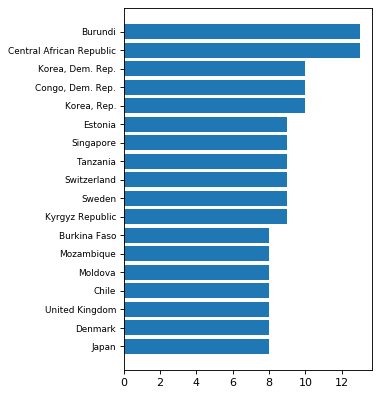

In [354]:
# which countries are most often efficient

nc = 18 # number of countries to display
freq_eff = eff[eff==1].sum(axis=1).sort_values(ascending=True)[-nc:]
freq_eff.index = [cid.loc[ii,'c'] for ii in freq_eff.index] # change country code to full name

y_pos = np.arange(nc)

fig, ax = plt.subplots(1, 1, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
ax.barh(y_pos, freq_eff)
ax.set_yticks(y_pos)
ax.set_yticklabels(freq_eff.index, fontsize=8);


### Boxplots, beanplots, etc.

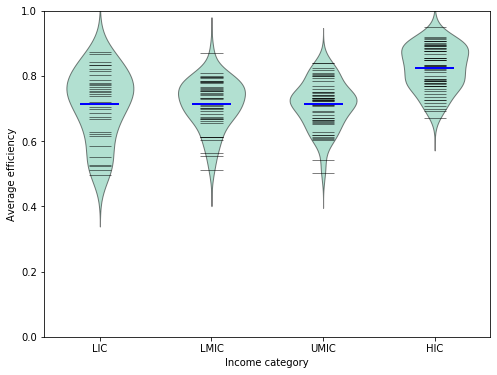

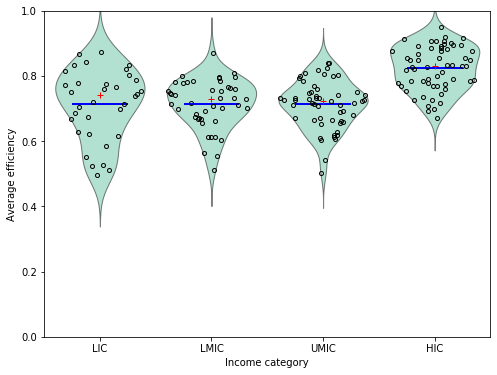

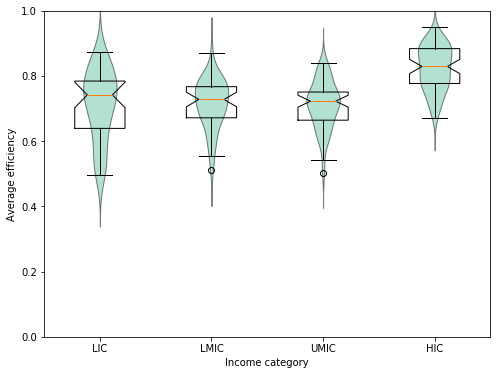

In [279]:
# beanplots - single

data = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
def bean(data, labels, plot_opts={}, jitter=False):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plot_opts_ = {}
    #              {'cutoff_val':5, 'cutoff_type':'abs',
    #             'label_fontsize':'small',
    #             'label_rotation':30}

    plot_opts_.update(plot_opts)
    sm.graphics.beanplot(data, ax=ax, labels=labels,
                         jitter=jitter, plot_opts=plot_opts_, side='both')
    ax.set_xlabel("Income category")
    ax.set_ylabel("Average efficiency")
    ax.set_ylim(0,1)

def violin(data, labels):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plot_opts={'violin_width':.3}
    sm.graphics.violinplot(data, ax=ax, labels=labels, plot_opts=plot_opts)
    ax.set_xlabel("Income category")
    ax.set_ylabel("Average efficiency")    
    ax.set_ylim(0,1)

# fig = bean([eff[cc] for cc in eff.columns[1:]], labels=eff.columns[1:])
fig = bean(data, labels=inc, plot_opts={'violin_width':.6, 'bean_size':.2, 'bean_show_median':False, 'bean_mean_size':.35})
fig = bean(data, labels=inc, jitter=True)
fig = violin(data, labels=inc)

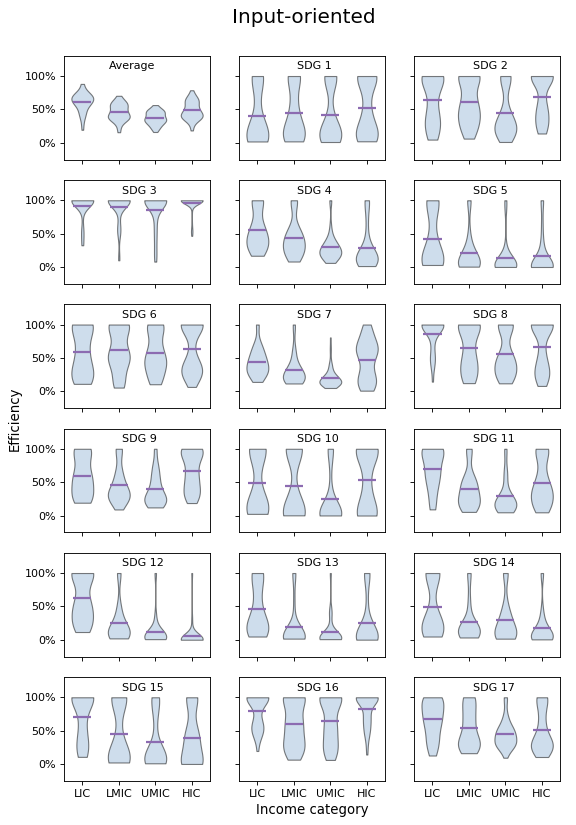

In [7]:
# beanplots - 6x3 grid

def bean(data, labels, ax, plot_opts={}, jitter=False):
    plot_opts_ = {}
    #              {'cutoff_val':5, 'cutoff_type':'abs',
    #             'label_fontsize':'small',
    #             'label_rotation':30}
    plot_opts_.update(plot_opts)
    sm.graphics.beanplot(data, ax=ax, labels=labels,
                         jitter=jitter, plot_opts=plot_opts_, side='both')
    # ax.set_xlabel("Income category")
    # ax.set_ylabel("Average efficiency")
    
def box(data, labels, ax):
    ax.boxplot(data, labels=labels, notch=False, whis=[5,95])

def violin_box(data, labels, ax, plot_opts={}):
    sm.graphics.violinplot(data, ax=ax, labels=labels, plot_opts=plot_opts)

def bean_jitter(data, labels, ax, plot_opts, jitter=True):
    sm.graphics.beanplot(data, ax=ax, labels=labels, jitter=jitter, plot_opts=plot_opts)

fig, ax = plt.subplots(6,3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True, sharey=True)
ax = ax.ravel()
for jj,ax0 in enumerate(ax):
    if jj == 0:
        data = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
        ax0.text(.31,.87,'Average',transform=ax0.transAxes)
        # ax0.set_title('Average')
    else:
        sdg_n = ''.join(('sdg',str(jj)))
        data = [eff[sdg_n][eff['income']==ii] for ii in inc]
        ax0.text(.4,.87,''.join(('SDG ',str(jj))),transform=ax0.transAxes)
        # ax0.set_title(sdg_n)

    ax0.set_ylim(-.25,1.3)
    ax0.set_yticklabels(('','0%','50%','100%'))
    # ax0.tick_params(axis='y', which='major', labelsize=8, pad=1)

    # add a big axis, hide frame
    ax3 = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax3.set_xlabel("Income category", fontsize=12)
    ax3.set_ylabel("Efficiency", fontsize=12, labelpad=15)
    fig.suptitle('Input-oriented', y=0.93, fontsize=18)

    
    # bean(data, inc, ax0, plot_opts={'violin_width':.6, 'bean_size':0, 'bean_show_median':False, 'bean_show_mean':False, 'bean_mean_size':.5, 'violin_fc':cmap[2,:], 'bean_mean_color':cmap[0,:], 'cutoff':True})
    # box(data, inc, ax0)
    # violin_box(data, inc, ax0, plot_opts={'cutoff':True})
    # bean_jitter(data, inc, ax0, plot_opts={'cutoff_val':5, 'cutoff_type':'abs', 'label_fontsize':'small',
    #                                       'label_rotation':30, 'violin_fc':(0.8, 0.8, 0.8), 'jitter_marker':'.',
    #                                       'jitter_marker_size':1, 'bean_color':'#FF6F00', 'bean_mean_color':'#009D91'})

    # bean_jitter(data, inc, ax0, plot_opts={'cutoff':True, 'violin_fc':(0.9, 0.9, 0.9), 'jitter_marker':'.',
    #                                       'jitter_marker_size':1.5, 'bean_color':cmap[0,:], 'bean_mean_color':cmap[2,:], 'bean_show_median':False})

    # only violin and mean, no data
    bean(data, inc, ax0, plot_opts={'violin_width':.6, 'bean_size':0, 'bean_show_median':False, 
                                    'bean_show_mean':True, 'bean_mean_size':.5, 'violin_fc':cmap[2,:], 
                                    'bean_mean_color':cmap[0,:], 'cutoff':True})
    
# plt.savefig('figures/abc.png', bbox_inches='tight', dpi=600)

### Histograms

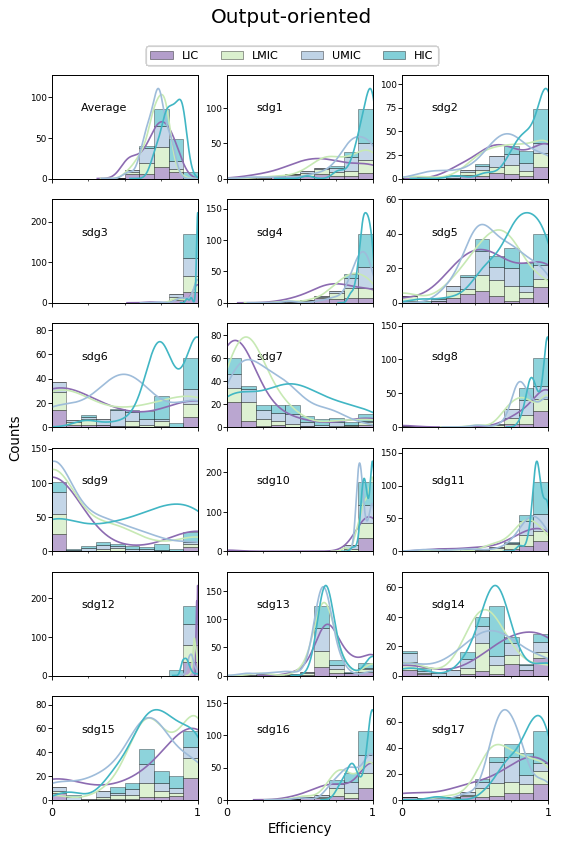

In [36]:
# stacked hist & KDE in one, every and all SDGs

aa = 0.6

def make_hist_kde(fig,ax):
    maxy2_mult = 1.15
    maxy1_mult = 1.5

    for jj,ax0 in enumerate(ax):
        ax00 = ax0.twinx()
        if jj == 0:
            histdata = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
            ax0.text(.2,.65,'Average',transform=ax0.transAxes)
            pos1 = ax0.get_position()
        else:
            sdg_n = ''.join(('sdg',str(jj)))
            histdata = [eff[sdg_n][eff['income']==ii] for ii in inc]
            ax0.text(.2,.65,sdg_n,transform=ax0.transAxes)

        ybins, xbins, _ = ax0.hist(histdata, bins=np.linspace(0, 1, num=11), stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2, alpha=aa)
        pd.concat(histdata, axis=1).plot.kde(color=cmap, ax = ax00, legend=False, alpha=1)
        ax0.set_xlim(0,1)

        # automatically adjust ylim for both axes
        maxy_hist = maxy1_mult*np.stack(ybins).max()
        ax0.set_ylim(0,maxy_hist)
        maxy_kde = maxy2_mult*max([ll.get_ydata().max() for ll in ax00.lines])
        ax00.set_ylim(0,maxy_kde)

        ax00.yaxis.set_visible(False)
        ax0.set_xticks([0,1])
        ax0.set_xticklabels([0,1])
        ax0.tick_params(axis='y', which='major', labelsize=8, pad=1)

        handles, labels = ax0.get_legend_handles_labels()
        leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=[0.5,0.9], ncol=4, bbox_transform=fig.transFigure)



fig, ax = plt.subplots(6,3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True)
ax = ax.ravel()
make_hist_kde(fig,ax)

# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel("Efficiency", fontsize=12)
ax3.set_ylabel("Counts", fontsize=12)


fig.suptitle('Input-oriented', y=0.95, fontsize=18)
# plt.savefig('figures/stackedhist2_kde_all_io.png', bbox_inches='tight', dpi=600)

if orient=='oo':
    fig.suptitle('Output-oriented', y=0.95, fontsize=18)
elif orient=='io':
    fig.suptitle('Input-oriented', y=0.95, fontsize=18)

plt.savefig('figures/kde_hist_{0}.png'.format(orient), bbox_inches='tight', dpi=600)



In [26]:
# histogram of average efficies across SDGs, stacked by income category

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
plt.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)

plt.xlabel('Average efficiency')
plt.ylabel('Number of countries')
plt.legend()

# reverse legend order
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

NameError: name 'nbins' is not defined

(0, 4)

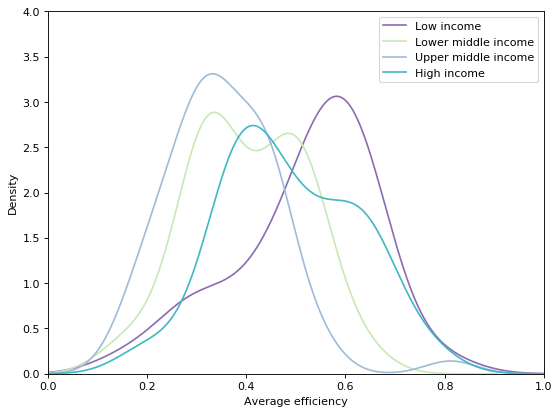

In [14]:
# KDE plot of average efficiencies across SDGs, for each income category

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]

ax = pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax = plt.gca())
plt.xlabel('Average efficiency')
plt.ylabel('Density')
plt.legend(['High income', 'Upper middle income', 'Lower middle income', 'Low income'][::-1])
# plt.axes([0,1.2,0,4])
ax.set_xlim(0,1)
ax.set_ylim(0,4)

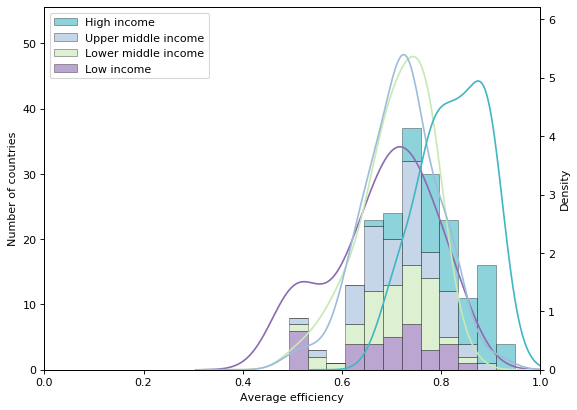

In [315]:
# stacked hist & KDE, in same plot
maxy2_mult = 1.15
maxy1_mult = 1.5

fig, ax = plt.subplots(1,1, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax2 = ax.twinx()

histdata = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
ybins, xbins, _ = ax.hist(histdata, bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2, alpha=.6)

pd.concat(histdata, axis=1).plot.kde(color=cmap, ax = ax2, legend=False, alpha=1)
ax.set_xlim(0,1)

# automatically adjust ylim for both axes
maxy_hist = maxy1_mult*np.stack(ybins).max()
ax.set_ylim(0,maxy_hist)
maxy_kde = maxy2_mult*max([ll.get_ydata().max() for ll in ax2.lines])
ax2.set_ylim(0,maxy_kde)

ax.set_ylabel('Number of countries')
# ax.set_xlabel('Average efficiency')
ax.set_xlabel('Average efficiency')
# ax.set_ylabel('Estimated density')

# legend in correct order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'], loc=2)

***
***
## old not-so-good ideas below

Text(0.5, 1.0, 'Input-oriented')

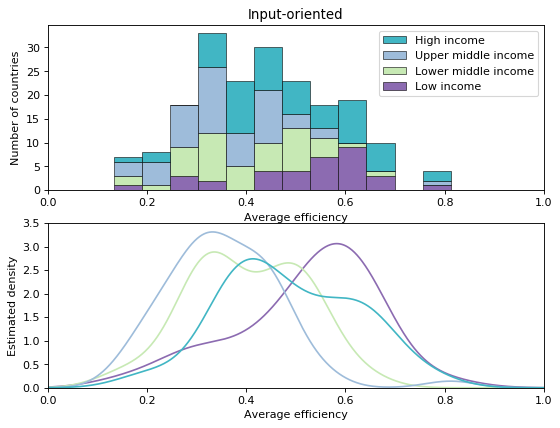

In [58]:
# stacked hist & KDE, in subplots

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6), dpi=80, sharex=False, facecolor='w', edgecolor='k')
ax1.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax = ax2, legend=False)
ax1.set_xlim(0,1)
ax2.set_xlim(0,1)
ax2.set_ylim(0,3.5)
ax1.set_ylabel('Number of countries')
ax1.set_xlabel('Average efficiency')
ax2.set_xlabel('Average efficiency')
ax2.set_ylabel('Estimated density')

# legend in correct order
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

ax1.set_title('Input-oriented')

# plt.savefig('figures/stackedhist_kde_io.png', bbox_inches='tight', dpi=600)


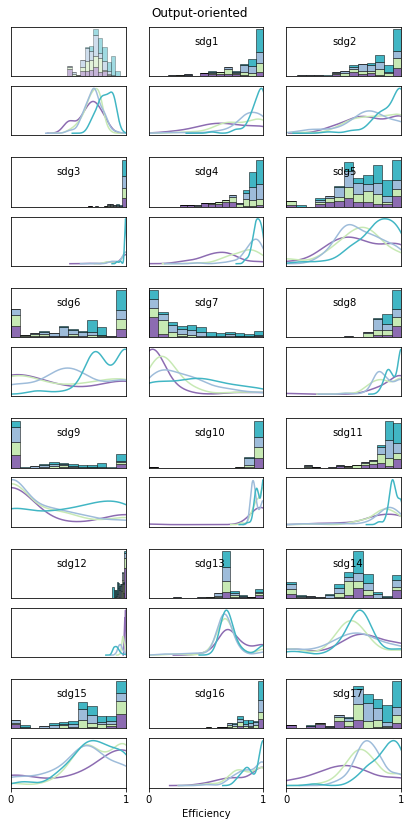

In [178]:
# stacked hist & KDE as subplots, every and all SDGs

def format_subplots(ax0,ax1):
    ax0.set_xlim(0,1)
    ax1.set_xlim(0,1)
    # ax0.set_ylim(0,100)
    # ax1.set_ylim(0,100)
    ax0.get_yaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax0.get_xaxis().set_visible(False)
    
def allsdg_hist_kde(fig):
    a = 1
    ax0 = fig.axes[0]
    ax1 = fig.axes[1]
    ax0.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
    av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
    pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax=ax1, legend=False)
    format_subplots(ax0,ax1)
    ax1.get_xaxis().set_visible(False)
    ax0.set_ylabel('Histogram')
    ax1.set_ylabel('Density')

def onesdg_hist_kde(fig):
    for jj, (ax0,ax1) in enumerate(zip(fig.axes[2::2], fig.axes[3::2])):
        sdg_n = ''.join(('sdg',str(jj+1)))
        ax0.hist([eff[sdg_n][eff['income']==ii] for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
        single_eff = [eff[sdg_n][eff['income']==ii] for ii in inc]
        pd.concat(single_eff, axis=1).plot.kde(color=cmap, ax=ax1, legend=False)
        format_subplots(ax0,ax1)
        ax0.text(.4,.65,sdg_n,transform=ax0.transAxes)
        if jj>=14:
            ax1.set_xticks([0,1])
            ax1.set_xticklabels([0,1])
            if jj == 15:
                ax1.set_xlabel('Efficiency')
        else:
            ax1.get_xaxis().set_visible(False)


f = plt.figure()
gs0 = gridspec.GridSpec(6, 3, figure=f)
for ii in range(18):
    gs01 = gs0[ii].subgridspec(2,1)
    f.add_subplot(gs01[0])
    f.add_subplot(gs01[1])

allsdg_hist_kde(f)
onesdg_hist_kde(f)
f.suptitle('Output-oriented', y=0.9)
f.set_size_inches([7,14])

# plt.savefig('figures/stackedhist_kde_all_oo.png', bbox_inches='tight', dpi=600)

In [ ]:
# if ax.is_last_row():
#     ax.spines['bottom'].set_visible(True)
# if ax.is_first_col():